In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import random
import cv2
import tensorflow as tf
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate, Activation,Dropout,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Loading Images & Create DataFrame

In [11]:
image_path = r"D:\INSTANT(Course)\Training Month\Sprint2\Project Computer Vision\MRI\lgg-mri-segmentation"

In [12]:
data = pd.read_csv("D:\INSTANT(Course)\Training Month\Sprint2\Project Computer Vision\MRI\kaggle_3m\data.csv")

In [13]:
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [15]:
import os
import glob
import pandas as pd

image_path = r"D:\INSTANT(Course)\Training Month\Sprint2\Project Computer Vision\MRI\lgg-mri-segmentation\kaggle_3m"

data_path = []


for file_path in glob.glob(os.path.join(image_path, "**", "*.tif"), recursive=True):
    filename = os.path.basename(file_path)


    patient_id = "_".join(filename.split("_")[:4])
    is_mask = "_mask" in filename

    data_path.append({
        "patient_id": patient_id,
        "img_path": file_path,
        "is_mask": is_mask
    })


df = pd.DataFrame(data_path)
print(df.shape)
df.head()


(7858, 3)


,patient_id,img_path,is_mask
0,TCGA_CS_4941_19960909,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,False
1,TCGA_CS_4941_19960909,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,False
2,TCGA_CS_4941_19960909,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,True
3,TCGA_CS_4941_19960909,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,False
4,TCGA_CS_4941_19960909,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,True


In [16]:
def data_frame(data):


    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))  
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))       


    IDs = list(map(lambda x: os.path.basename(x)[:-4], images))


    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))        
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))        



    def diagnostic_function(mask_path):
        try:
            img = Image.open(mask_path)
            return 1 if np.max(np.array(img)) > 0 else 0
        except:
            return 0  


    diagnoses = list(map(diagnostic_function, masks))


    df = pd.DataFrame({
        'ID': IDs,
        'image': images,
        'Mask': masks,
        'Diagnosis': diagnoses
    })


    train_idx, val_idx = train_test_split(df.index.tolist(), test_size=0.19, random_state=42)
    val_idx, test_idx = train_test_split(val_idx, test_size=0.12, random_state=42)

    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    test_df = df.iloc[test_idx]

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [17]:
train_df, val_df, test_df = data_frame(df['img_path'].tolist())


In [18]:
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (3182, 4)
Val: (657, 4)
Test: (90, 4)


In [19]:
train_df

,ID,image,Mask,Diagnosis
0,TCGA_DU_7302_19911203_33,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
1,TCGA_HT_7602_19951103_17,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
2,TCGA_DU_A5TR_19970726_31,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
3,TCGA_DU_5872_19950223_26,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
4,TCGA_FG_7643_20021104_17,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
...,...,...,...,...
3177,TCGA_DU_5872_19950223_48,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
3178,TCGA_HT_7693_19950520_4,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
3179,TCGA_DU_7304_19930325_9,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
3180,TCGA_FG_6688_20020215_14,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0


In [20]:
val_df  

,ID,image,Mask,Diagnosis
0,TCGA_FG_6692_20020606_4,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
1,TCGA_DU_7300_19910814_4,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
2,TCGA_DU_7302_19911203_30,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
3,TCGA_DU_7302_19911203_26,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
4,TCGA_HT_7608_19940304_28,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
...,...,...,...,...
652,TCGA_CS_6665_20010817_12,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
653,TCGA_DU_A5TW_19980228_18,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
654,TCGA_FG_6691_20020405_3,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
655,TCGA_HT_7881_19981015_60,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0


In [21]:
test_df

,ID,image,Mask,Diagnosis
0,TCGA_DU_6408_19860521_49,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
1,TCGA_DU_6404_19850629_2,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
2,TCGA_DU_8165_19970205_13,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
3,TCGA_FG_7637_20000922_23,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
4,TCGA_HT_7860_19960513_12,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
...,...,...,...,...
85,TCGA_CS_6669_20020102_17,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
86,TCGA_HT_8107_19980708_18,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
87,TCGA_DU_6399_19830416_13,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1
88,TCGA_DU_6405_19851005_49,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,1


In [22]:
print(train_df.columns)
train_df.head()


Index(['ID', 'image', 'Mask', 'Diagnosis'], dtype='object')


,ID,image,Mask,Diagnosis
0,TCGA_DU_7302_19911203_33,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
1,TCGA_HT_7602_19951103_17,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
2,TCGA_DU_A5TR_19970726_31,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
3,TCGA_DU_5872_19950223_26,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0
4,TCGA_FG_7643_20021104_17,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,D:\INSTANT(Course)\Training Month\Sprint2\Proj...,0


# Visualization

In [23]:
def mask_has_tumor(mask_path):
    mask = np.array(Image.open(mask_path).convert('L'))
    return np.max(mask) > 0

train_df['has_tumor'] = train_df['Mask'].apply(mask_has_tumor)


tumor_counts = train_df['has_tumor'].value_counts()
print("Tumor Distribution:")
print(tumor_counts)


Tumor Distribution:
has_tumor
False    2075
True     1107
Name: count, dtype: int64


In [24]:
def show_tumor_samples_with_diagnosis(df, count=5):
    
    
    shown = 0
    fig, axes = plt.subplots(count, 3, figsize=(15, 5 * count))
    
    if count == 1:
        axes = [axes]  

    for i in range(len(df)):
        row = df.iloc[i]

        image = np.array(Image.open(row['image']).convert('RGB'))
        mask = np.array(Image.open(row['Mask']).convert('L'))

        if np.max(mask) > 0:

            binary_mask = (mask > 0).astype(np.uint8)


            overlay = image.copy()
            overlay[binary_mask == 1] = [255, 0, 0]  


            ax = axes[shown] if count > 1 else axes

            ax[0].imshow(image)
            ax[0].set_title("Brain MRI")

            ax[1].imshow(binary_mask, cmap='gray')
            ax[1].set_title("Mask = 1")

            ax[2].imshow(overlay)
            ax[2].set_title("MRI with Mask = 1")

            for a in ax:
                a.axis('off')

            shown += 1
            if shown == count:
                break

    if shown == 0:
        print("No Tumor Detected")
    else:
        plt.tight_layout()
        plt.show()


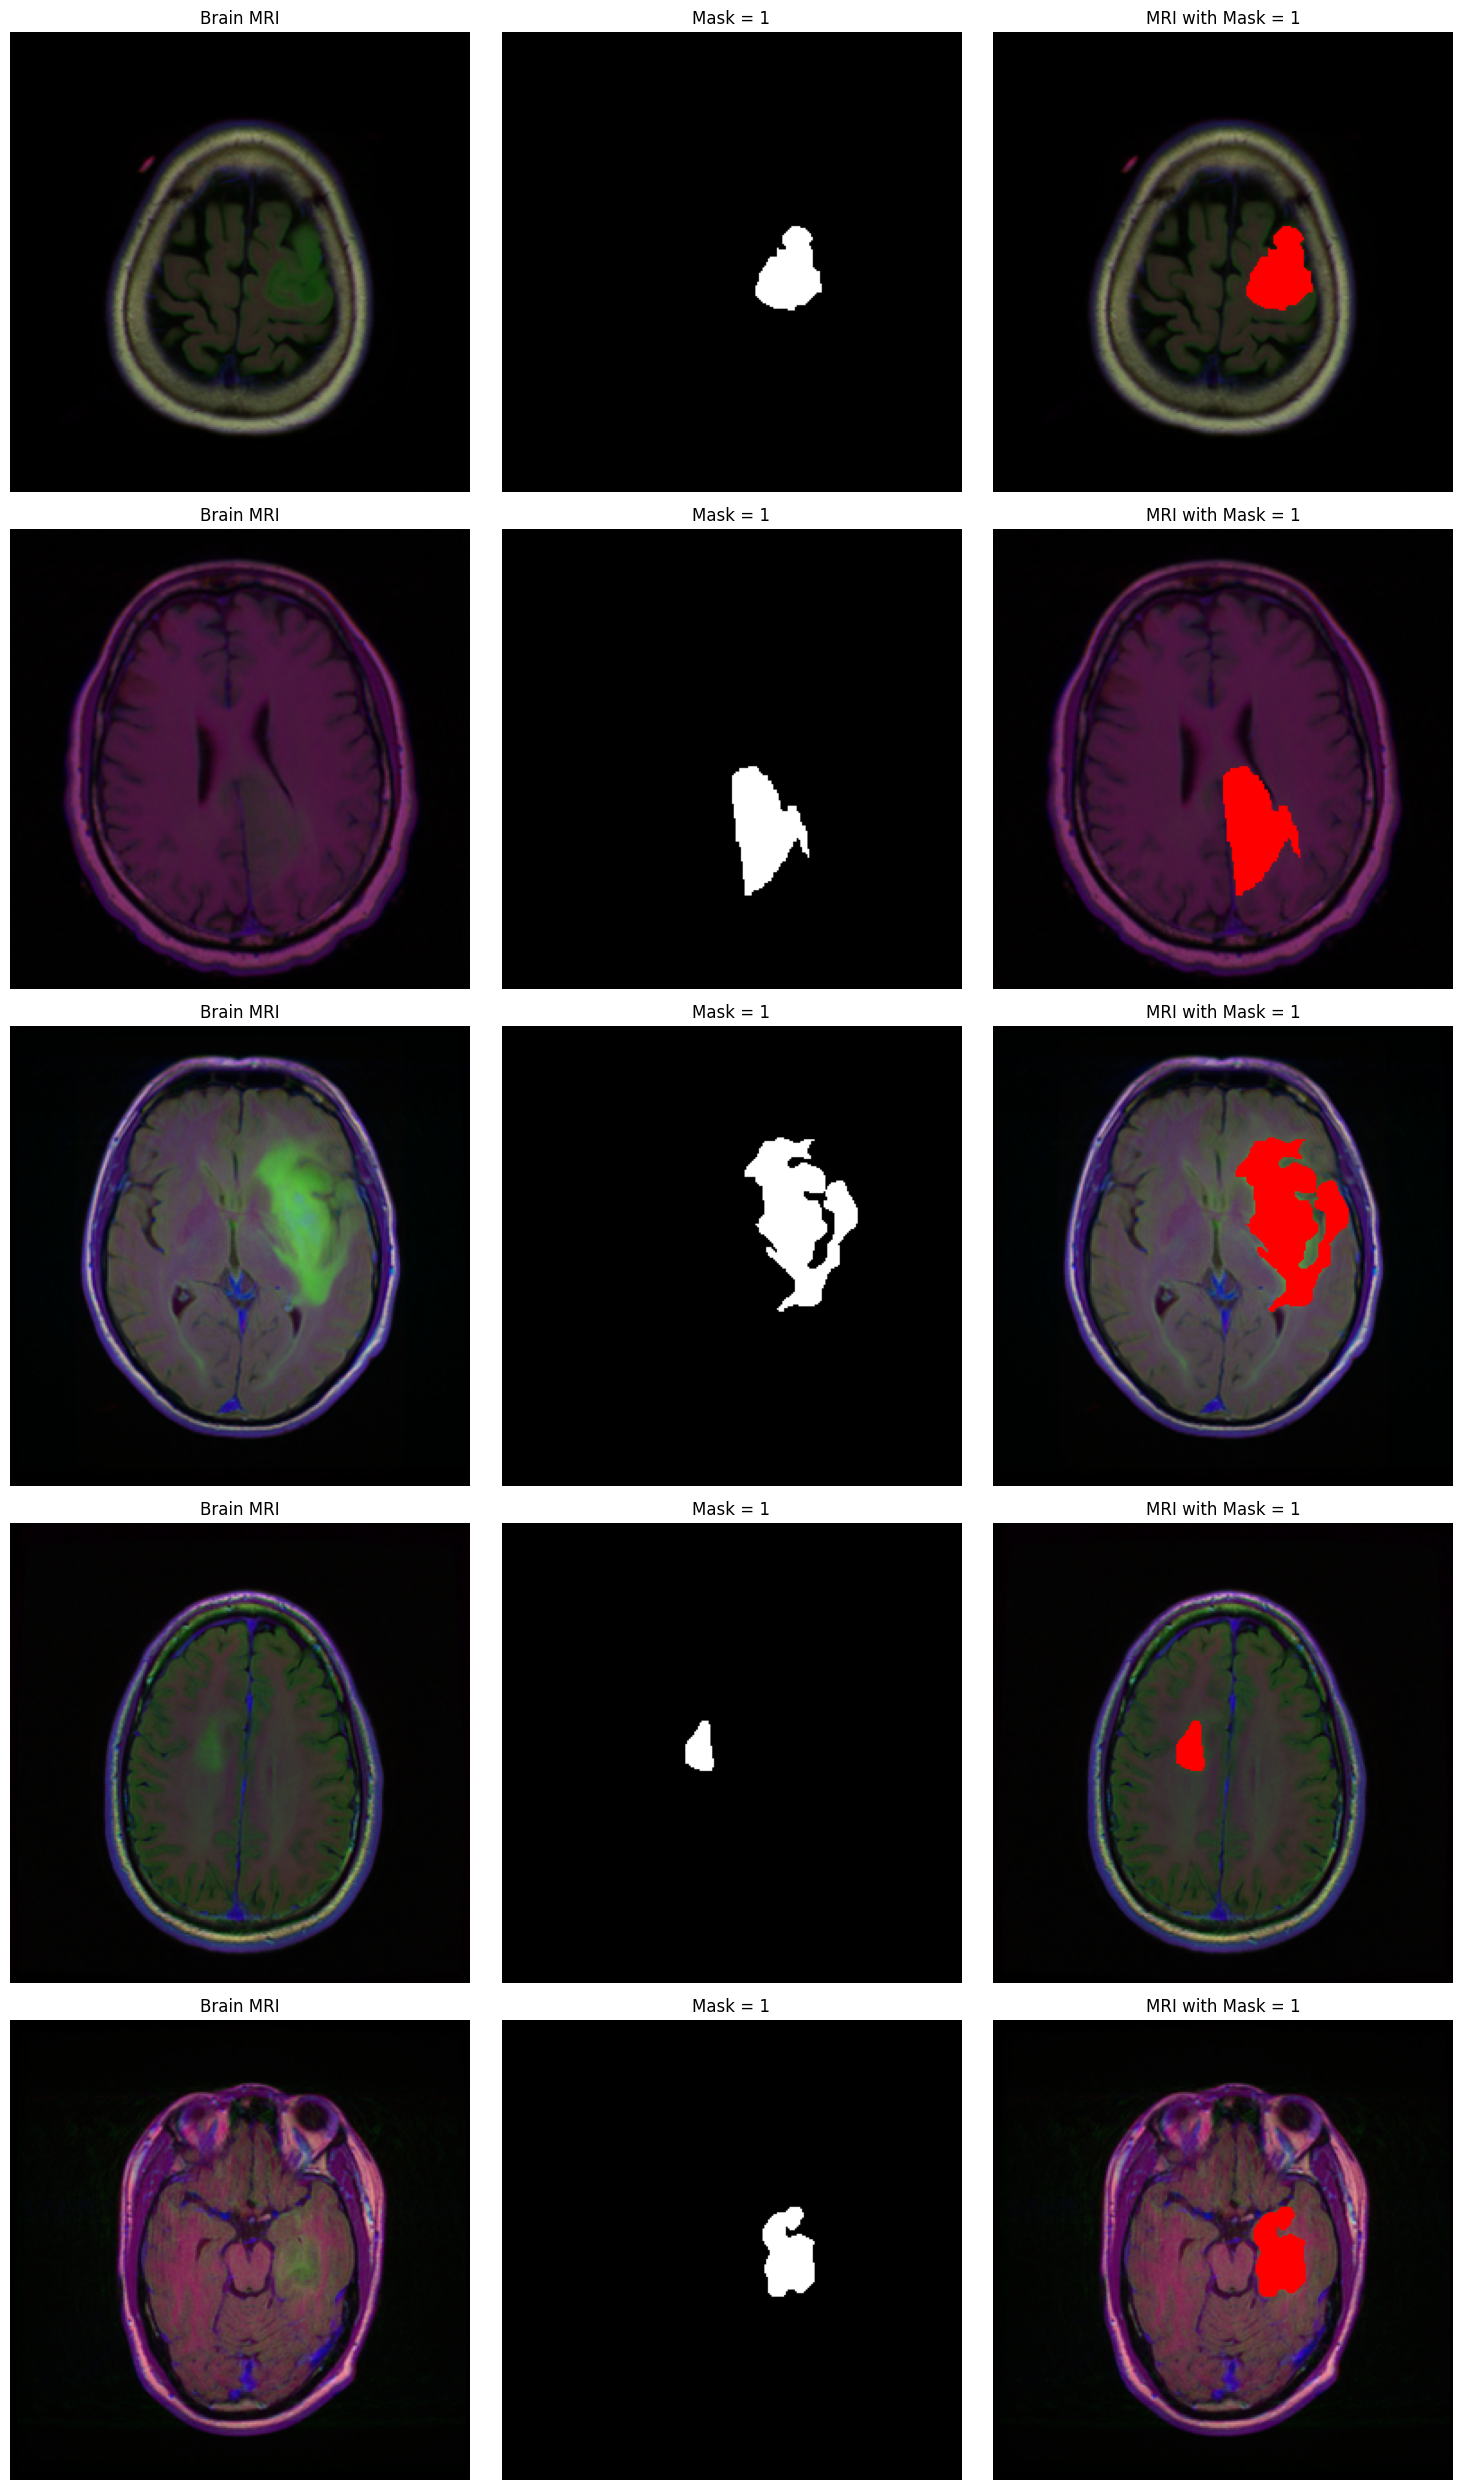

In [25]:
show_tumor_samples_with_diagnosis(train_df, count=5)


# Image Generator

In [26]:
batch_size = 4
target_size = (256, 256)


In [27]:
def normalize_mask(image, mask):
    image = image/255
    mask = mask/255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (image, mask)

In [28]:
def train_generator(
        data_frame, 
        batch_size, 
        aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256, 256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image",  
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="Mask",  
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_mask(img, mask) 
        yield (img, mask)


In [29]:
def val_generator(data_frame,
        batch_size,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image",  
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        seed=seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="Mask",  
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        seed=seed)

    val_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in val_gen:
        img, mask = normalize_mask(img, mask)
        yield (img, mask)


In [30]:
aug_dict = dict(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [31]:
train_gen = train_generator(train_df, batch_size= batch_size, 
                            aug_dict = aug_dict,
                            target_size = target_size)
test_gen = train_generator(val_df, batch_size = batch_size,
                           aug_dict = dict(),
                           target_size = target_size)

# UNet Architecture

In [32]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First Conv Layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv Layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def UNET(input_img, n_filters=32, dropout=0.1, batchnorm=True):


    c1 = conv2d_block(input_img, n_filters * 1, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, batchnorm=batchnorm)

 

    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [33]:
from tensorflow.keras import backend as K


def iou(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

 
def jac_distance(y_true, y_pred):
    return -iou(y_true, y_pred)


def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred) 


In [34]:
epoch = 30
learning_rate = 0.05
decay_rate = learning_rate / epoch
opt = Adam(learning_rate=learning_rate, epsilon= 0.1, decay=decay_rate, amsgrad=False)

In [35]:
input_img = Input((target_size[0],target_size[1],3), name='img')

model = UNET(input_img, n_filters=32, dropout=0.2, batchnorm=True)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [37]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    
    ModelCheckpoint('model-brain-mri-v9.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [38]:
history = model.fit(train_gen,
          steps_per_epoch = len(train_df)/batch_size,
          epochs = epoch,
          callbacks = callbacks,
          validation_data = test_gen,
          validation_steps= len(val_df)/ batch_size) 

Found 3182 validated image filenames.
Found 3182 validated image filenames.
Epoch 1/30
796/795 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9868 - iou: 0.1218 - dice_coef: 0.1958 - precision: 0.3383Found 657 validated image filenames.
Found 657 validated image filenames.

Epoch 1: val_loss improved from inf to 0.03636, saving model to model-brain-mri-v9.h5
795/795 [==============================] - 176s 206ms/step - loss: 0.0465 - accuracy: 0.9868 - iou: 0.1218 - dice_coef: 0.1958 - precision: 0.3383 - val_loss: 0.0364 - val_accuracy: 0.9890 - val_iou: 0.1497 - val_dice_coef: 0.2353 - val_precision: 0.4535
Epoch 2/30
796/795 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9924 - iou: 0.1824 - dice_coef: 0.2755 - precision: 0.7506
Epoch 2: val_loss improved from 0.03636 to 0.03318, saving model to model-brain-mri-v9.h5
795/795 [==============================] - 146s 183ms/step - loss: 0.0260 - accuracy: 0.9924 - iou: 0.1824 - dice_coef:

# Save & Load Model

In [44]:
model.save('model-brain-mri-Unet.h5')
 

# Evaluation

In [ ]:
test_gen = train_generator(test_df, batch_size,
                                dict(),
                                target_size=target_size)
"accuracy", iou, dice_coef,tf.keras.metrics.Precision()

results = model.evaluate(test_gen, steps=len(test_df) / batch_size)
print("Test loss: ",results[0])
print("Test IoU: ",results[2])
print("Test Dice Coefficient: ",results[3])
print("Test Precision: ",results[4])

Found 90 validated image filenames.
Found 90 validated image filenames.
22/22 [==============================] - 2s 86ms/step - loss: 0.0274 - accuracy: 0.9912 - iou: 0.2379 - dice_coef: 0.3482 - precision: 0.5675
Test loss:  0.027367467060685158
Test IoU:  0.23794540762901306
Test Dice Coefficient:  0.34817036986351013
Test Precision:  0.5674949288368225


1/1 [==============================] - 0s 20ms/step


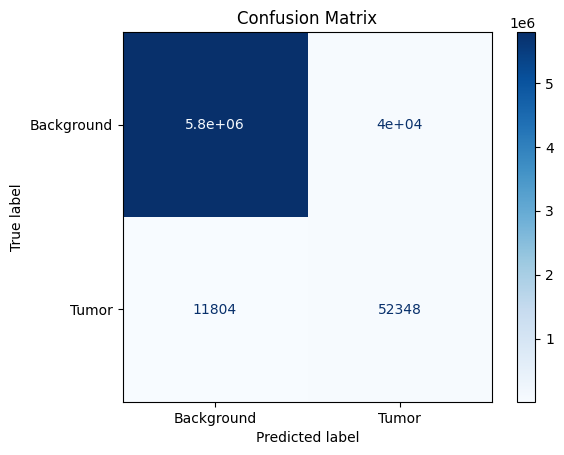

Confusion Matrix:
 [[5794193   39895]
 [  11804   52348]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import cv2
import matplotlib.pyplot as plt


all_preds = []
all_trues = []


for i in range(len(test_df)):
    image_path = test_df.iloc[i]['image']
    mask_path = test_df.iloc[i]['Mask']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size)

    img_input = image_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    pred = model.predict(img_input)[0, :, :, 0]

    pred_binary = (pred > 0.5).astype(np.uint8).flatten()
    mask_binary = (mask_resized > 127).astype(np.uint8).flatten()

    all_preds.extend(pred_binary)
    all_trues.extend(mask_binary)

cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Tumor"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", cm)


In [42]:
report = classification_report(
    all_trues,
    all_preds,
    target_names=["Background", "Tumor"],
    digits=4
)

print(report)

              precision    recall  f1-score   support

  Background     0.9980    0.9932    0.9956   5834088
       Tumor     0.5675    0.8160    0.6694     64152

    accuracy                         0.9912   5898240
   macro avg     0.7827    0.9046    0.8325   5898240
weighted avg     0.9933    0.9912    0.9920   5898240



1/1 [==============================] - 0s 22ms/step


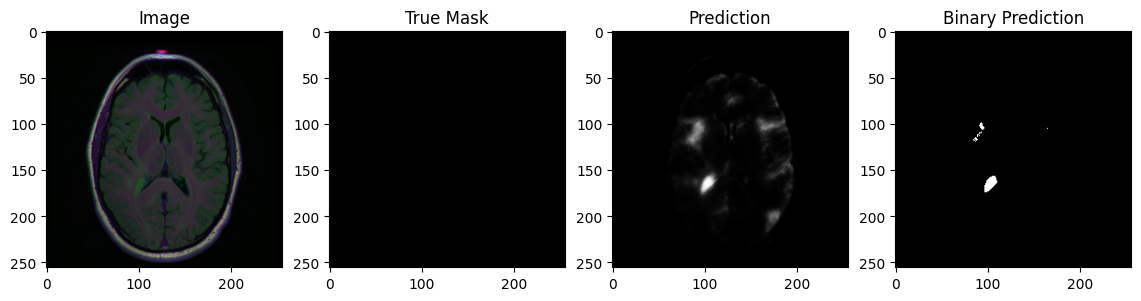

1/1 [==============================] - 0s 22ms/step


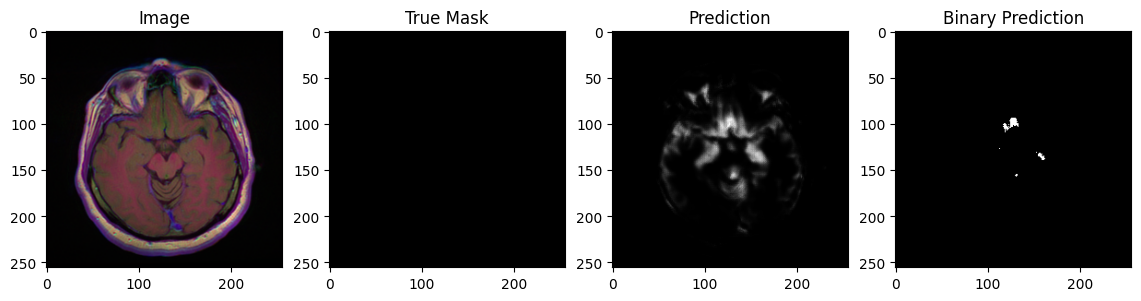

1/1 [==============================] - 0s 20ms/step


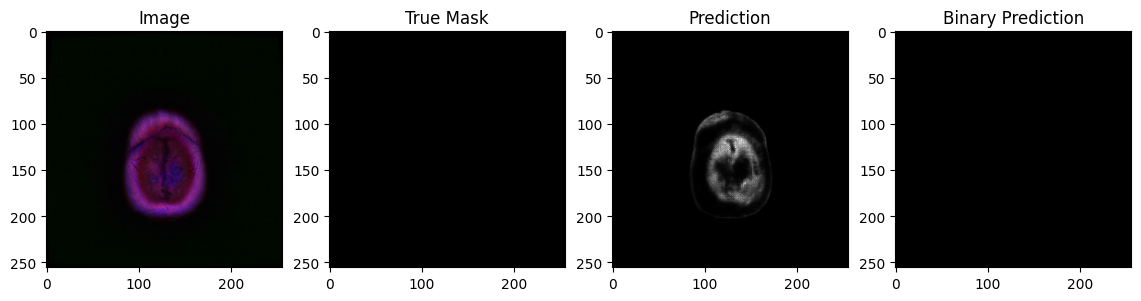

1/1 [==============================] - 0s 20ms/step


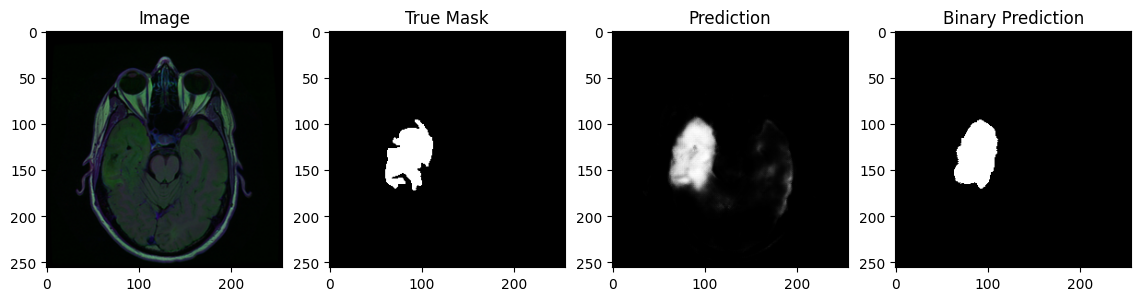

1/1 [==============================] - 0s 23ms/step


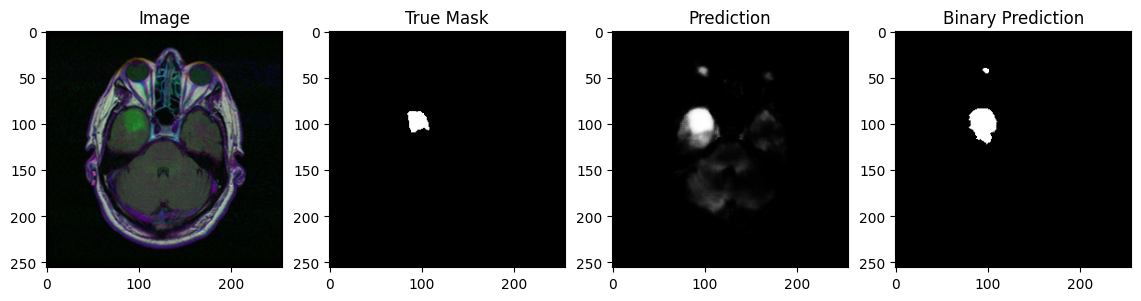

1/1 [==============================] - 0s 20ms/step


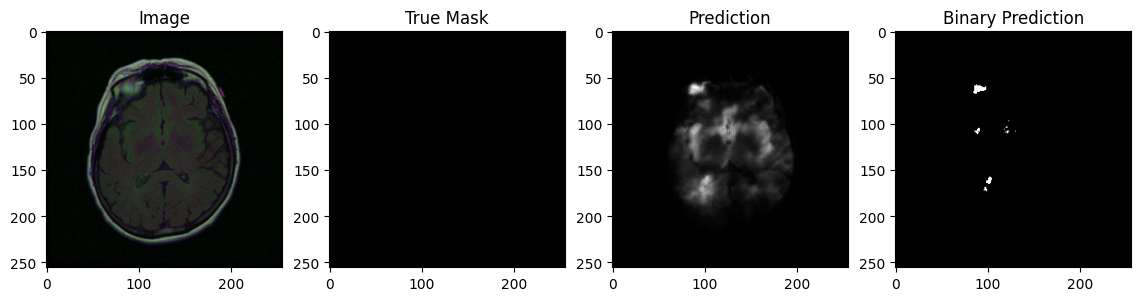

1/1 [==============================] - 0s 20ms/step


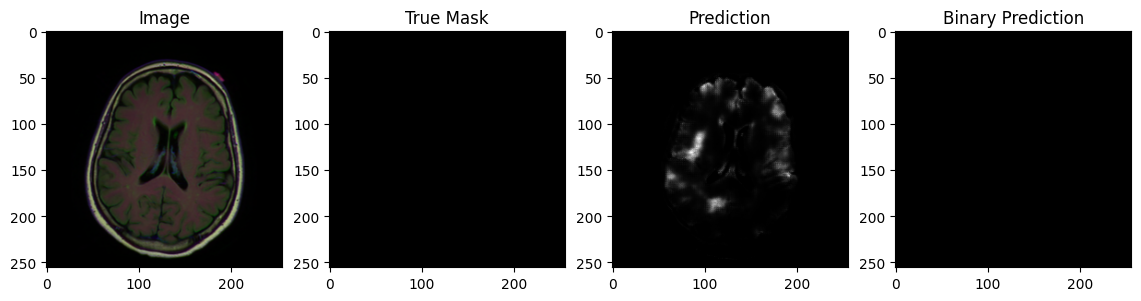

1/1 [==============================] - 0s 20ms/step


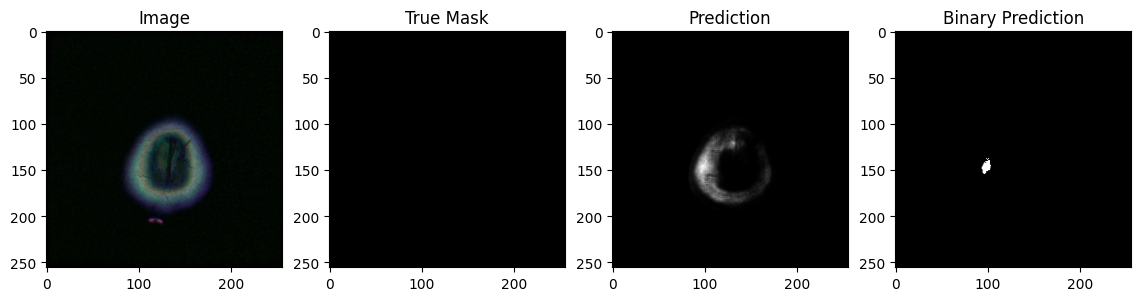

1/1 [==============================] - 0s 27ms/step


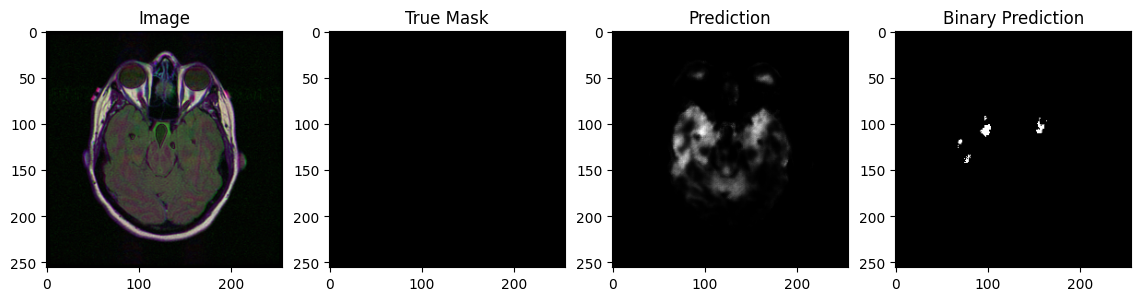

1/1 [==============================] - 0s 21ms/step


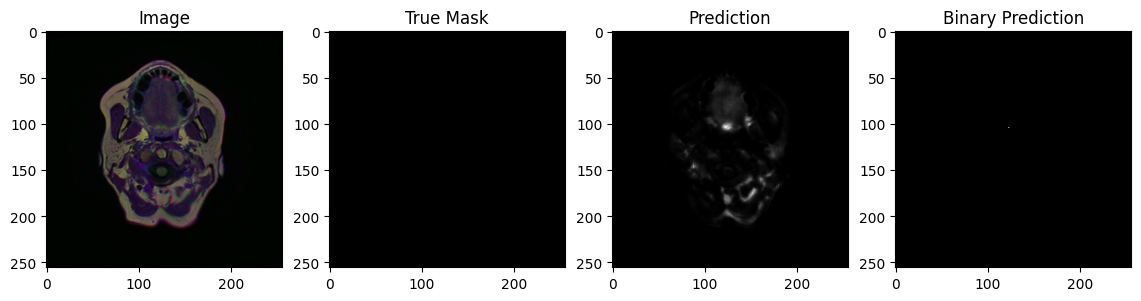

1/1 [==============================] - 0s 21ms/step


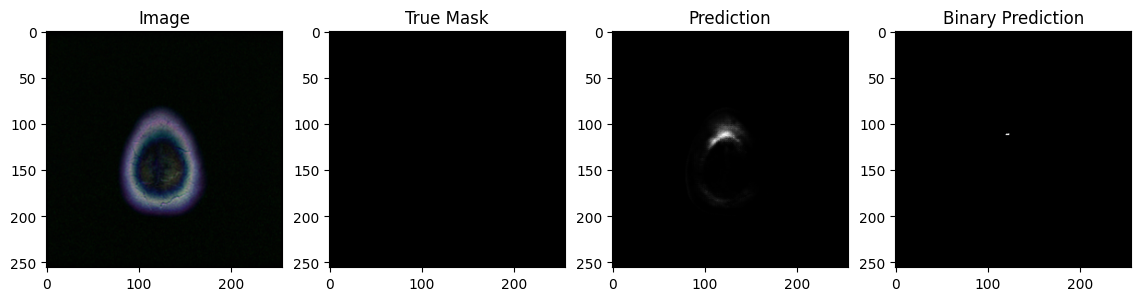

1/1 [==============================] - 0s 21ms/step


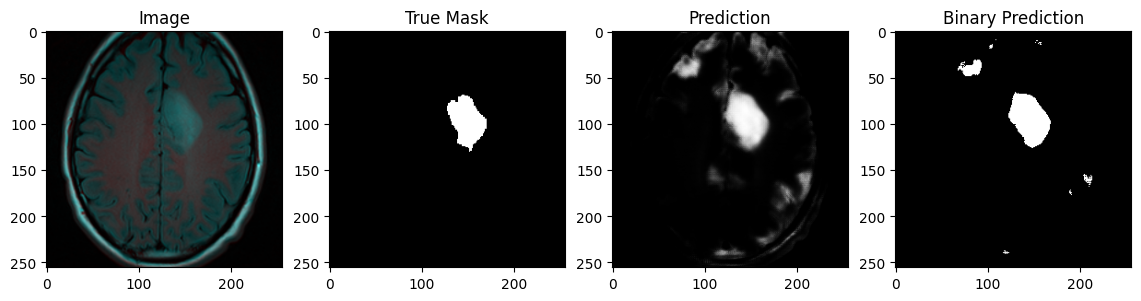

1/1 [==============================] - 0s 31ms/step


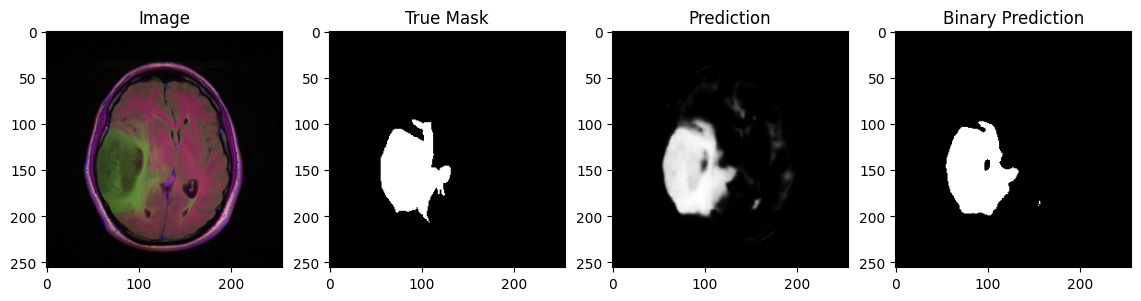

1/1 [==============================] - 0s 21ms/step


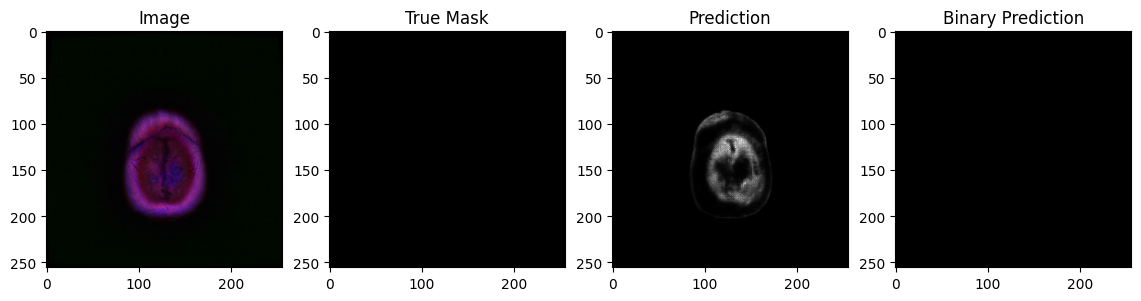

1/1 [==============================] - 0s 21ms/step


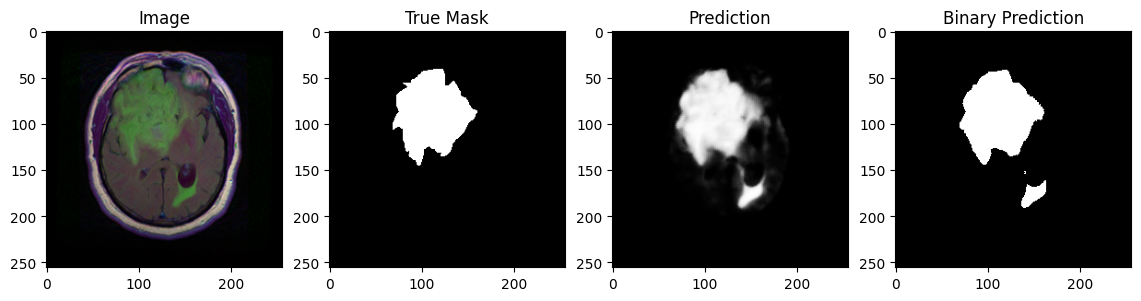

In [ ]:
for i in range(15):
    idx = random.randint(0, len(test_df) - 1)

    image_path = test_df.iloc[idx]['image']
    mask_path = test_df.iloc[idx]['Mask']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size)

    img_input = image_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    pred = model.predict(img_input)[0, :, :, 0]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image_resized)
    plt.title("Image")

    plt.subplot(1, 4, 2)
    plt.imshow(mask_resized, cmap="gray")
    plt.title("True Mask")

    plt.subplot(1, 4, 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Prediction")

    plt.subplot(1, 4, 4)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Binary Prediction")
    plt.show()
